In [1]:
####################################################
## Hurricane Ida Analysis                         ##
## @brett | 09-05-2021                            ##
####################################################

# Getting Data Ready

In [2]:
from matplotlib import pyplot

In [3]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib import pyplot


# Change some settings
pd.options.display.max_rows = 999

# Import Data
last_year = pd.read_csv('./../data/Calls_for_service_2020.csv')
this_year = pd.read_csv('./../data/Calls_for_service_2021.csv')

# Merge into one dataset
data = this_year.append(last_year).reset_index().drop('index',axis=1)

# Read New Orleans Shapefile available here (https://portal-nolagis.opendata.arcgis.com/datasets/neighborhood-statistical-areas/explore)
no = gpd.read_file('./../data/Neighborhood_Statistical_Areas.zip')
no = no.to_crs(epsg=4326)

# Constants
CRS = "EPSG:4326"

In [4]:
def get_latlon(s, lat=True):
    '''
    Helper Function to extract lat/lon from string
    '''
    try:
        t = s.replace('(','').replace(')','').split(' ')
        x = t[1]
        y = t[2]
        if(lat):
            return(float(x))
        else:
            return(float(y))
    except:
        return(None)

In [5]:
data['lat'] = data.Location.apply(lambda x: get_latlon(x, True))
data['lon'] = data.Location.apply(lambda x: get_latlon(x, False))

In [6]:
geometry = gpd.points_from_xy(data.lat, data.lon, crs=CRS)
geo_df = gpd.GeoDataFrame(data, crs=CRS, geometry=geometry)

In [7]:
import censusdata
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2015)

{'Mississippi': censusgeo((('state', '28'),)),
 'Missouri': censusgeo((('state', '29'),)),
 'Montana': censusgeo((('state', '30'),)),
 'Nebraska': censusgeo((('state', '31'),)),
 'Nevada': censusgeo((('state', '32'),)),
 'New Hampshire': censusgeo((('state', '33'),)),
 'New Jersey': censusgeo((('state', '34'),)),
 'New Mexico': censusgeo((('state', '35'),)),
 'New York': censusgeo((('state', '36'),)),
 'North Carolina': censusgeo((('state', '37'),)),
 'North Dakota': censusgeo((('state', '38'),)),
 'Ohio': censusgeo((('state', '39'),)),
 'Oklahoma': censusgeo((('state', '40'),)),
 'Oregon': censusgeo((('state', '41'),)),
 'Pennsylvania': censusgeo((('state', '42'),)),
 'Rhode Island': censusgeo((('state', '44'),)),
 'South Carolina': censusgeo((('state', '45'),)),
 'South Dakota': censusgeo((('state', '46'),)),
 'Tennessee': censusgeo((('state', '47'),)),
 'Texas': censusgeo((('state', '48'),)),
 'Vermont': censusgeo((('state', '50'),)),
 'Utah': censusgeo((('state', '49'),)),
 'Virgin

In [8]:
# This cleans the date, if there is no date there, I fill in a date from 1900 so that I can easily filter it out
def clean_date(s):
    try:
        return(datetime.strptime(s,'%m/%d/%Y %I:%M:%S %p'))
    except:
        return(None)

In [9]:
# Let's clean up some of these fun timestamps
data['DateCreate'] = data['TimeCreate'].apply(lambda x: datetime.strptime(x[:10],'%m/%d/%Y'))
data['TimeCreate'] = data['TimeCreate'].apply(lambda x: clean_date(x))
data['TimeDispatch'] = data['TimeDispatch'].apply(lambda x: clean_date(x))
data['TimeArrive'] = data['TimeArrive'].apply(lambda x: clean_date(x))
data['TimeClosed'] = data['TimeClosed'].apply(lambda x: clean_date(x))

# Let's start exploring

First off, going to look at overall counts and the changes that happened

In [10]:
day_counts = data[['DateCreate', 'TimeCreate']].groupby('DateCreate').count().reset_index()
day_counts.columns = ['date', 'count']

[Text(0, 0.5, 'count of incidents')]

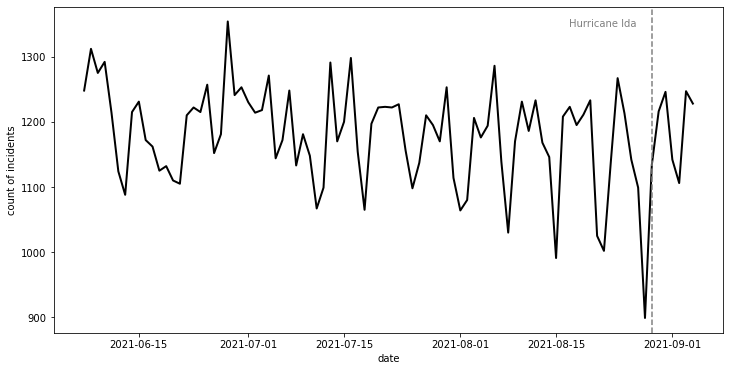

In [11]:
fig,ax = plt.subplots(figsize = (12,6))
sns.lineplot(x="date", y="count",
             data=day_counts[-90:], color='black', linewidth=2)
ax.axvline(datetime.strptime('20210829','%Y%m%d'), color='grey', linestyle='--')
ax.text(0.82, 0.95,'Hurricane Ida',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, color='grey')
ax.set(ylabel='count of incidents')

Looks like it is an anomaly for how low it is on the day before the hurricane...I wonder why. how does that fit into the distribution?

In [14]:
day_counts['count'].describe()

count     613.000000
mean     1191.401305
std        91.173981
min       899.000000
25%      1133.000000
50%      1188.000000
75%      1248.000000
max      1534.000000
Name: count, dtype: float64

In [17]:
# check z-score
z = (899-1191.4)/91.173981
z

-3.2070553110980216

[Text(0.5, 0, 'count of daily incidents')]

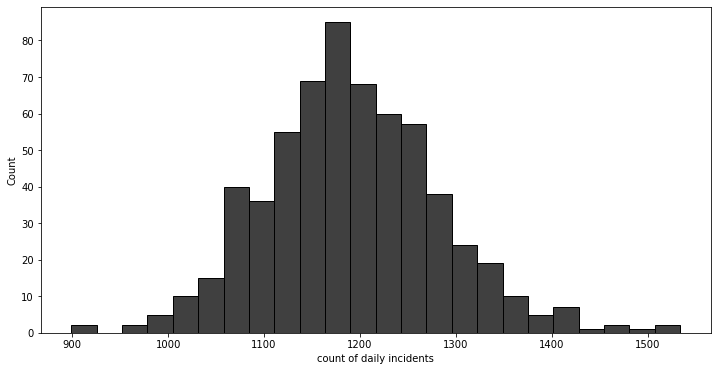

In [51]:
fig,ax = plt.subplots(figsize = (12,6))
sns.histplot(day_counts['count'], color='black')
ax.set(xlabel='count of daily incidents')

So the day before the Hurricane saw the lowest amount of incidents ever. Why do we think that is? Could it be that the policeforce was busy doing something else to help prep the community?

[Text(0, 0.5, 'count of incidents'), Text(0.5, 0, 'date')]

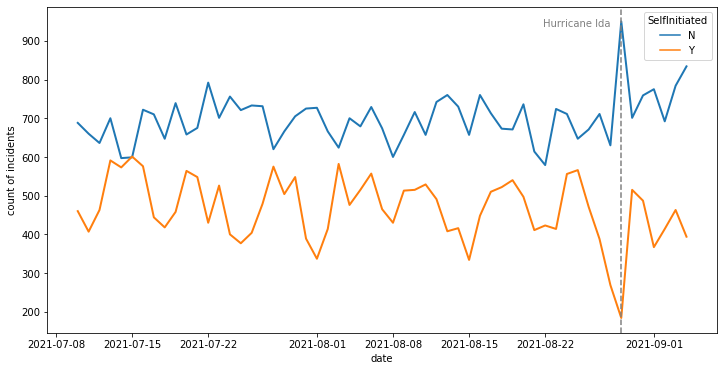

In [52]:
s = data[data.TimeCreate>='2021-07-10']
types = s[['DateCreate', 'SelfInitiated', 'TimeClosed']].groupby(['DateCreate', 'SelfInitiated']).count().reset_index()
fig,ax = plt.subplots(figsize = (12,6))
sns.lineplot(data=types, x="DateCreate", y="TimeClosed", hue="SelfInitiated", linewidth=2)
ax.axvline(datetime.strptime('20210829','%Y%m%d'), color='grey', linestyle='--')
ax.text(0.79, 0.95,'Hurricane Ida',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, color='grey')
ax.set(ylabel='count of incidents', xlabel='date')

Sure looks like it. The number of self-initiatied incidents went down significantly.

In [26]:
data['DispositionText']

0         Necessary Action Taken
1         Necessary Action Taken
2               REPORT TO FOLLOW
3               REPORT TO FOLLOW
4                      UNFOUNDED
                   ...          
730324    Necessary Action Taken
730325    Necessary Action Taken
730326    Necessary Action Taken
730327           GONE ON ARRIVAL
730328    Necessary Action Taken
Name: DispositionText, Length: 730329, dtype: object

[Text(0, 0.5, 'count of incidents'), Text(0.5, 0, 'date')]

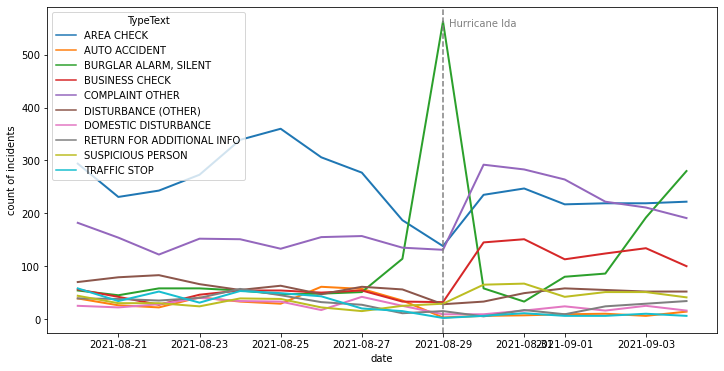

In [18]:
s = data[data.TimeCreate>='2021-08-20']
types = s[['DateCreate', 'TypeText', 'TimeClosed']].groupby(['DateCreate', 'TypeText']).count().reset_index()
fig,ax = plt.subplots(figsize = (12,6))
sns.lineplot(data=types[types.TypeText.isin(['AREA CHECK','COMPLAINT OTHER','DISTURBANCE (OTHER)','BUSINESS CHECK','BURGLAR ALARM, SILENT','RETURN FOR ADDITIONAL INFO','TRAFFIC STOP','SUSPICIOUS PERSON','AUTO ACCIDENT','DOMESTIC DISTURBANCE'])], x="DateCreate", y="TimeClosed", hue="TypeText", linewidth=2)
ax.axvline(datetime.strptime('20210829','%Y%m%d'), color='grey', linestyle='--')
ax.text(0.65, 0.95,'Hurricane Ida',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, color='grey')
ax.set(ylabel='count of incidents', xlabel='date')

Meanwhile, burglar alarms started to account for a rise. Also, while there was a spike, the upward trend continued.

We should probably also look at it by census tract

In [28]:
j = gpd.sjoin(geo_df, no, how="left", op='intersects')

[Text(0, 0.5, 'count of incidents'), Text(0.5, 0, 'date')]

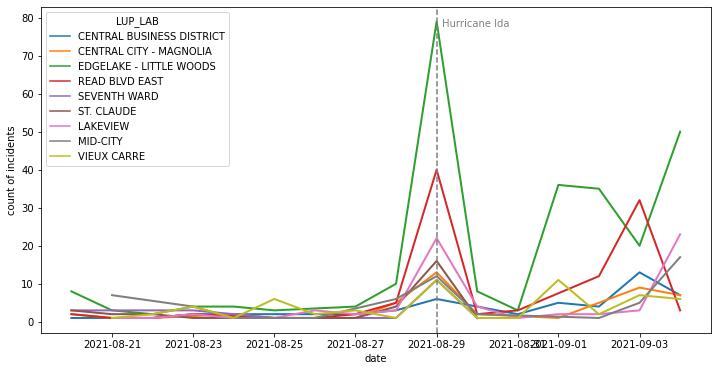

In [29]:
s = j[(j.TimeCreate>='2021-08-20')&(j.TypeText=='BURGLAR ALARM, SILENT')]
types = s[['DateCreate', 'LUP_LAB', 'TimeClosed']].groupby(['DateCreate', 'LUP_LAB']).count().reset_index()
fig,ax = plt.subplots(figsize = (12,6))
sns.lineplot(data=types[types.LUP_LAB.isin(['EDGELAKE - LITTLE WOODS', 'LAKEVIEW', 'READ BLVD EAST', 'CENTRAL BUSINESS DISTRICT', 'MID-CITY', 'ST. CLAUDE', 'CENTRAL CITY - MAGNOLIA', 'VIEUX CARRE', 'SEVENTH WARD'])], x="DateCreate", y="TimeClosed", hue="LUP_LAB", linewidth=2)
ax.axvline(datetime.strptime('20210829','%Y%m%d'), color='grey', linestyle='--')
ax.text(0.65, 0.95,'Hurricane Ida',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, color='grey')
ax.set(ylabel='count of incidents', xlabel='date')

<AxesSubplot:>

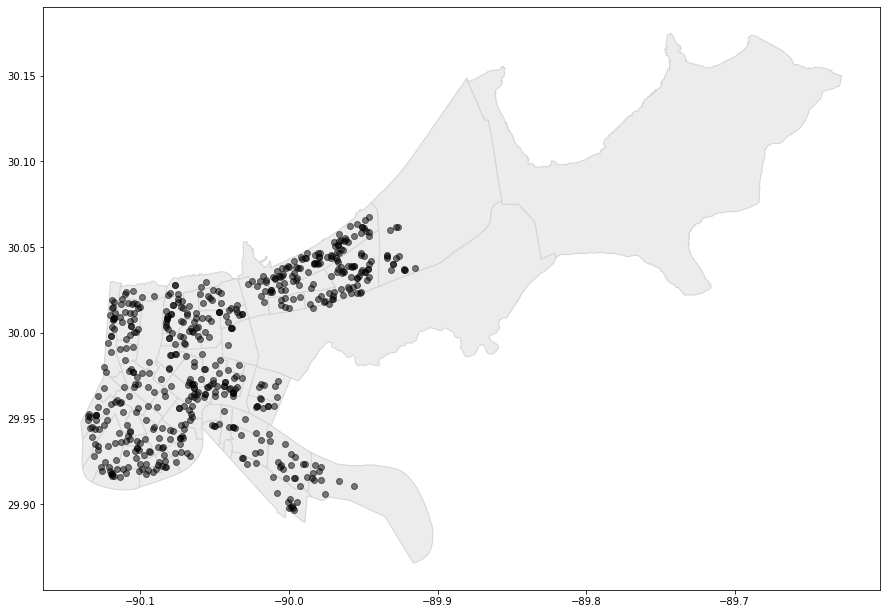

In [92]:
fig,ax = plt.subplots(figsize = (15,15))
no.plot(ax = ax,color="#ECECEC", edgecolor="#D4D4D4")
# in_bounds[in_bounds.DateCreate==r]['geometry'].plot(ax=ax, color=geo_df['TypeTextCleaned'].map(color_mapping), alpha = 0.5)
geo_df[(geo_df.DateCreate=='2021-08-29')&(geo_df.TypeText=='BURGLAR ALARM, SILENT')]['geometry'].plot(color='black', ax=ax, alpha=0.5)

In [94]:
# This is a pretty stupid field that doesn't really tell me a whole lot
geo_df[(geo_df.DateCreate>='2021-08-29')&(geo_df.TypeText=='BUSINESS CHECK')]['DispositionText'].value_counts()

Necessary Action Taken    799
Name: DispositionText, dtype: int64

<AxesSubplot:>

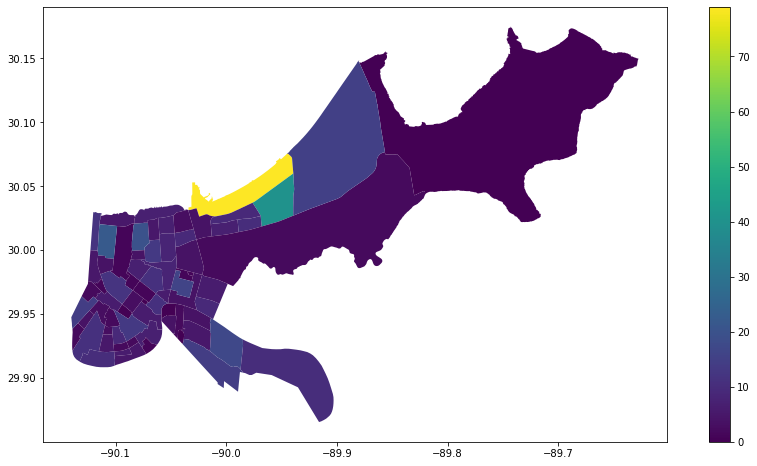

In [95]:
ba = j[(j.DateCreate=='2021-08-29')&(j.TypeText=='BURGLAR ALARM, SILENT')][['NOPD_Item', 'LUP_LAB']].groupby('LUP_LAB').count().reset_index()
ba.columns = ['LUP_LAB','count']
a = pd.merge(no,ba,how='left',on='LUP_LAB').fillna(0)
fig,ax = plt.subplots(figsize = (15,8))

a.plot(column='count',ax=ax, legend=True)